In [3]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():

    device_name = torch.cuda.get_device_name(0)  # Assuming you want the first GPU
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: NVIDIA A100-PCIE-40GB


648 cells simulated


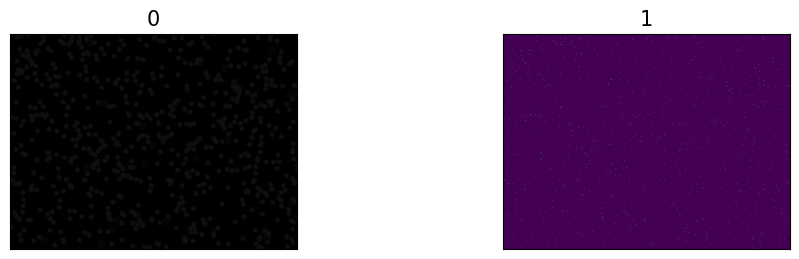

In [4]:


import matplotlib.pylab as plt
import numpy as np
# import tensorflow as tf
import scipy.ndimage as ndimage
from skimage import draw
from skimage.filters import gaussian
from scipy.ndimage import gaussian_filter
import cv2

FULL_IMG_WIDTH = 800
FULL_IMG_HEIGHT = 600
IMG_CHANNELS = 3
PATCH_WIDTH = 128
PATCH_HEIGHT = 128
stride = 64
INPUT_WIDTH = PATCH_WIDTH*2
INPUT_HEIGHT = PATCH_HEIGHT*2

# A function that generate the synthetic dataset

def generate_image(with_intermediates=False):
    
  # the image has a random black background that is smoothed
  backgr = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH, IMG_CHANNELS])
  backgr[ np.random.rand(FULL_IMG_HEIGHT, FULL_IMG_WIDTH) < 0.3, 1 ] = 0
  backgr[ np.random.rand(FULL_IMG_HEIGHT, FULL_IMG_WIDTH) < 0.3, 2 ] = 0
  backgr = ndimage.gaussian_filter(backgr, sigma=(5, 5, 0), order=0)

  # between 0 to 1000 cells randomly placed
  num_cells = np.random.randint(0, 1000)
  cell_cx = np.random.randint(0, FULL_IMG_WIDTH, size=num_cells)
  cell_cy = np.random.randint(0, FULL_IMG_HEIGHT, size=num_cells)
  label = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
  label[cell_cy, cell_cx] = 1

  num_nuncells = np.random.randint(1, 25)
  nun_cell_cy = np.random.randint(0, FULL_IMG_HEIGHT, size=num_nuncells)
  nun_cell_cx = np.random.randint(0, FULL_IMG_WIDTH, size=num_nuncells)


  img = np.copy(backgr)
  cells = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
  
  #Addting noise
  for idx in range(len(nun_cell_cy)):

        rr, cc = draw.disk((nun_cell_cy[idx], nun_cell_cx[idx]),
                             radius=12,
                             shape=cells.shape)
        cells[rr, cc] = 5        
  img[cells == 5] = [5, 5, 5]
    
    
  for idx in range(len(cell_cy)):

        rr, cc = draw.disk((cell_cy[idx], cell_cx[idx]),
                             radius=8,
                             shape=cells.shape)
        cells[rr, cc] = 10.0   
  img[cells == 10.0] = [8, 8, 8]

  # draw the cells with 6 px in radius
  for idx in range(len(cell_cy)):
    
    rr, cc = draw.disk((cell_cy[idx], cell_cx[idx]),
                         radius=6,
                         shape=cells.shape)
    cells[rr, cc] = 1.0   
  img[cells == 1] = [15, 15, 15]


    # print("{} cells simulated".format(num_cells))
  if with_intermediates:
    print("{} cells simulated".format(num_cells))
    return img, label
  else:
    return img, label


import matplotlib.pyplot as plt
import os
from PIL import Image

images = generate_image(True)
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(images):
    # print(type(file))
    img = Image.fromarray(file.astype(np.uint8))
    # print('Image shape: ', np.array(img).shape)
    if i < 3:
        ax = fig.add_subplot(2, 2, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img)
        ax.set_title(i, size=15)
    
#plt.savefig('figures/12_03.pdf')
plt.tight_layout()
plt.show()

In [3]:
images[0].shape

(600, 800, 3)

In [5]:
import torch
import torch.nn.functional as F

def get_patches(img, label, verbose=False):
    img = torch.unsqueeze(img, dim=0)
    img = img.permute(0, 3, 2, 1)
    label = torch.unsqueeze(torch.unsqueeze(label, dim=0), dim=-1)
    label = label.permute(0, 3, 2, 1)
    
    if verbose:
        print(img.shape, label.shape)

    num_patches = ((FULL_IMG_WIDTH - PATCH_WIDTH) / stride + 1) * ((FULL_IMG_HEIGHT  - PATCH_HEIGHT) / stride + 1)
    patches = F.unfold(img, kernel_size=(PATCH_HEIGHT, PATCH_WIDTH), stride=stride, padding=1).cuda()
    patches = patches.view(-1, 3, PATCH_HEIGHT, PATCH_WIDTH).cuda()

    labels = F.unfold(label, kernel_size=(PATCH_HEIGHT, PATCH_WIDTH), stride=stride, padding = 1).cuda()
    # print("Labels: ", labels.shape)
    labels = labels.view(patches.shape[0], -1).cuda()


    # the "density" is the number of points in the label patch
    patch_labels = labels.sum(dim=1, keepdim=True).cuda()
    
    if verbose:
        print(patches.shape, labels.shape, patch_labels.shape)

    return patches, patch_labels

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomCellDataset(Dataset):
    def __init__(self, num_full_images):
        self.num_full_images = num_full_images

    def __len__(self):
        return self.num_full_images 

    def __getitem__(self, idx):
        # print(self.num_full_images * (FULL_IMG_HEIGHT // PATCH_HEIGHT) ** 2)
        img, label = generate_image()

        img = torch.from_numpy(img).cuda()
        label = torch.from_numpy(label).cuda()


        patches, patch_labels = get_patches(img , label)
   
        return patches, patch_labels

#Test
train_dataset = CustomCellDataset(num_full_images=2)
train_loader = DataLoader(train_dataset, batch_size=None, shuffle=False)

for i, data in enumerate(train_loader):
    img, label = data
    

In [7]:
# wrapper for the actual dataset

import torch
from torch.utils.data import Dataset, DataLoader

class CellDataset(Dataset):
    def __init__(self, images_test, labels_test):
        self.imgs = images_test
        self.labels = labels_test
        # self.num_full_images = num_full_images

    def __len__(self):
         return len(self.imgs)
       

    def __getitem__(self, idx):
        # img, label = generate_image()

        img = self.imgs[idx]
        # print(img)
        # img = torch.from_numpy(img.astype(np.float64))
        img = cv2.imread(img).astype(np.uint16)

        # print(img.shape)
        label_path = self.labels[idx]
        coord = pd.read_csv(label_path)
        label = np.zeros((img.shape[0], img.shape[1]))
        for i in range(coord.shape[0]):
            label[int(coord['Y'][i]), int(coord['X'][i])] = 1

        img = torch.from_numpy(img.astype(np.float64))
        label = torch.from_numpy(label)

        patches, patch_labels = get_patches(img , label)
        # for patch, patch_label in zip(patches, patch_labels):
        return patches, patch_labels

In [8]:
#Data organization from the given folder 

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob as glob
import os
import random

#Dataset path
data_path = "IDCIA"

images = glob.glob(os.path.join(data_path, 'images', '*/*.tiff'))
labels = glob.glob(os.path.join(data_path, 'ground_truth', '*/*.csv'))

images = sorted(list(filter(None, images)))
labels = sorted(list(filter(None, labels)))

print("number of images: ", len(images))
print("number of labels: ", len(labels))

number of images:  250
number of labels:  250


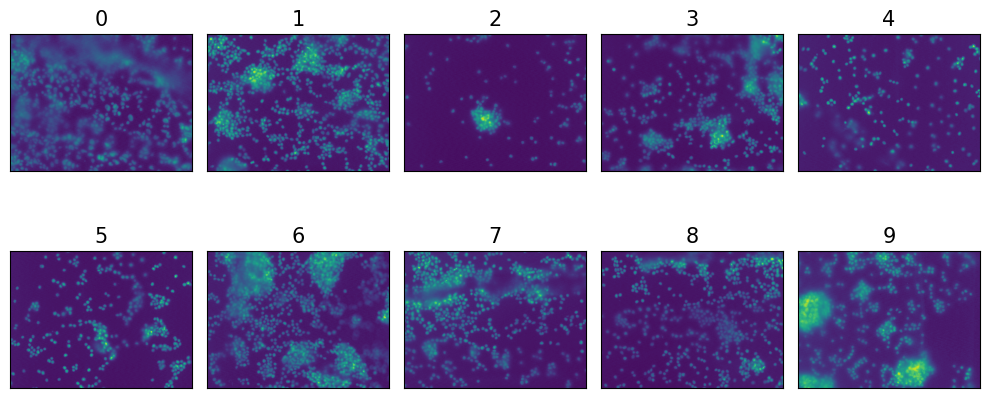

In [9]:
#Visualization of the actual dataset

import matplotlib.pyplot as plt
import os
from PIL import Image


fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(images):
    # print(type(file))
    img = Image.open(file)
    # print(i)
    
    # ax.imshow(img)
    # print(type(img))
    # print('Image shape: ', np.array(img).shape)
    if i < 10:
        ax = fig.add_subplot(2, 5, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img)
        ax.set_title(i, size=15)
    
#plt.savefig('figures/12_03.pdf')
plt.tight_layout()
plt.show()


In [12]:
#Regression CNN model 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define a custom model class
class CellCountingModel(nn.Module):
    def __init__(self, num_filters):
        super(CellCountingModel, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(num_filters, num_filters , kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv3 = nn.Conv2d(num_filters , num_filters , kernel_size=3, padding=0)
        self.fc1 = nn.Linear(800, num_filters )
        self.fc2 = nn.Linear(num_filters , 1)

    def forward(self, x):
        # batch_size = batch_size.cpu()
        # x = x.view(-1, x.size(2), x.size(3), x.size(4))  # Reshape to [batch_size * time, channels, height, width]
        
        x = x.type(torch.float32)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool1(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool2(x)
        x = nn.functional.relu(self.conv3(x))
        # print(x.shape)
        x = x.view(x.size(0), -1)  # Flatten
        # print(x.shape)
        x = nn.functional.relu(self.fc1(x.cuda()))
        x = self.fc2(x)
        return x

In [11]:
#splitting the actual dataset into 60%, 40% for training and testing respectively
import random
image_label_pair = [(image, label) for image, label in zip(images, labels)]
random.shuffle(image_label_pair)

val_size = int(0.40 * len(image_label_pair)) 
train_size = len(image_label_pair) - val_size 
image_label_pair_train = image_label_pair[:train_size]
image_label_pair_test = image_label_pair[train_size:]

images_train, images_test, labels_train, labels_test = [], [], [], []
for pair in image_label_pair_train:
    images_train.append(pair[0])
    labels_train.append(pair[1])

for pair in image_label_pair_test:
    images_test.append(pair[0])
    labels_test.append(pair[1])

In [11]:
#Data preparation for training and testing 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, random_split

# Train
NUM_TRAIN = 1000 # 10000
NUM_EVAL = 250 # 1000
batch_size=16
learning_rate=0.001
l1=0
l2=0
num_filters=32
num_epochs=100

hyperparameters = ["learning rate", "num_epochs", "num_sythetic_data", "training_mse", "training_mae", "test_mse", "test_mae", "test_acp"]
data_dicc = {col:[] for col in hyperparameters}
data_dicc["learning rate"].append(learning_rate)
data_dicc["num_epochs"].append(num_epochs)
data_dicc["num_sythetic_data"].append(NUM_TRAIN)

# Training and Evaluation datasets
synthetic_train_dataset  = CustomCellDataset(NUM_TRAIN)


#actual dataset
actual_train_dataset    = CellDataset(images_train, labels_train)
actual_test_dataset    = CellDataset(images_test, labels_test)

train_dataset = ConcatDataset([synthetic_train_dataset, actual_train_dataset])

#dataloader
eval_loader  = DataLoader(actual_test_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create an instance of the model
model = CellCountingModel(num_filters).float()

# Create the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

if torch.cuda.is_available():
    model = model.cuda()

In [35]:
hyperparameters = ["learning rate", "num_epochs", "num_sythetic_data", "training_mse", "training_mae", "test_mse", "test_mae", "test_acp"]
data_dicc = {col:[] for col in hyperparameters}
data_dicc["learning rate"].append(learning_rate)
data_dicc["num_epochs"].append(num_epochs)
data_dicc["num_sythetic_data"].append(NUM_TRAIN)

In [12]:
#ACP evaluation metric
import torch

def acp_estimate(pred_list, gt_list):
    y_hat = torch.tensor(pred_list)
    y = torch.tensor(gt_list)

    # Calculate the absolute difference
    abs_diff = torch.abs(y_hat - y)
    
    # Check the condition |y_hat - y| <= 0.05 * y
    condition = abs_diff <= 0.05 * y

    # Calculate the percentage of elements satisfying the condition
    acp = (torch.sum(condition).item() / len(y)) * 100

    return acp

Epoch 1/100: Train_MSE: 9.6604, Val_RMSE: 6.1493, Val_MAE: 3.9581
Epoch 2/100: Train_MSE: 6.5146, Val_RMSE: 5.6454, Val_MAE: 3.8113
Epoch 3/100: Train_MSE: 5.6858, Val_RMSE: 4.7973, Val_MAE: 3.3807
Epoch 4/100: Train_MSE: 5.5140, Val_RMSE: 5.3260, Val_MAE: 3.6825
Epoch 5/100: Train_MSE: 5.6036, Val_RMSE: 6.7078, Val_MAE: 5.1833
Epoch 6/100: Train_MSE: 5.4960, Val_RMSE: 5.5412, Val_MAE: 4.0045
Epoch 7/100: Train_MSE: 5.5863, Val_RMSE: 4.9598, Val_MAE: 3.4531
Epoch 8/100: Train_MSE: 5.4797, Val_RMSE: 4.9276, Val_MAE: 3.5538
Epoch 9/100: Train_MSE: 5.6629, Val_RMSE: 5.1053, Val_MAE: 3.5822
Epoch 10/100: Train_MSE: 5.6108, Val_RMSE: 5.1055, Val_MAE: 3.7653
Epoch 11/100: Train_MSE: 5.6363, Val_RMSE: 6.6999, Val_MAE: 4.3006
Epoch 12/100: Train_MSE: 5.5130, Val_RMSE: 5.5343, Val_MAE: 3.9357
Epoch 13/100: Train_MSE: 5.7976, Val_RMSE: 4.8292, Val_MAE: 3.5872
Epoch 14/100: Train_MSE: 5.5544, Val_RMSE: 4.5975, Val_MAE: 3.2748
Epoch 15/100: Train_MSE: 5.4434, Val_RMSE: 5.6257, Val_MAE: 4.2443
Epoc

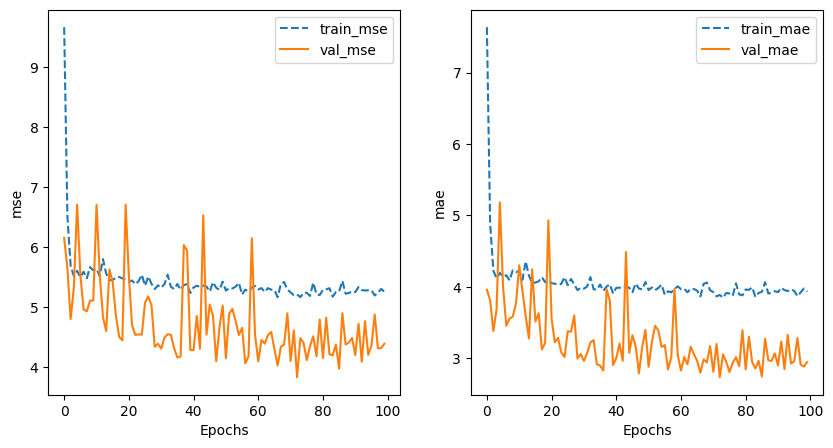

In [13]:
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error

def training_plot(metrics, train_history, val_history):
    import matplotlib.pyplot as plt
    f, ax = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(train_history['train_' + metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(val_history['val_' + metric])
        ax[idx].legend(['train_' + metric, 'val_' + metric])
    plt.savefig('model_accuracy_1.png', dpi=300)


def train_and_evaluate():

    val_history = {'val_mse': [], 'val_mae': []}
    train_history = {'train_mse': [], 'train_mae': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_train_mae = 0.0
        for inputs, labels in train_loader:
            
            inputs = inputs.view(-1, inputs.size(2), inputs.size(3), inputs.size(4))  # Reshape to [batch_size * time, channels, height, width]
            labels = labels.view(-1, 1) 

            if torch.cuda.is_available():
                 inputs, labels, batch_size = inputs.cuda(), labels.cuda(), torch.tensor(inputs.size(0)).cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, labels.to(torch.float)))
            train_mae = F.l1_loss(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_train_mae += train_mae.item()

        train_average_mse = total_loss / len(train_loader)
        train_average_mae = total_train_mae / len(train_loader)
        train_history['train_mse'].append(train_average_mse)
        train_history['train_mae'].append(train_average_mae)

        # Validation
        model.eval()
        total_mse = 0.0
        total_mae = 0.0

        with torch.no_grad():
            for inputs, labels in eval_loader:
                inputs = inputs.view(-1, inputs.size(2), inputs.size(3), inputs.size(4))  # Reshape to [batch_size * time, channels, height, width]
                labels = labels.view(-1, 1)
                if torch.cuda.is_available():
                    inputs, labels = inputs.cuda(), labels.cuda()
                    
                # model.fc1 = nn.Linear(torch.tensor(inputs.size(0)).cuda(), torch.tensor(32*5*5).cuda())
                # print(inputs.shape)
                outputs = model(inputs)
                mse = torch.sqrt(criterion(outputs, labels))
                mae = F.l1_loss(outputs, labels)
                # mae = torch.mean(torch.abs(outputs - labels))

                total_mse += mse.item()
                total_mae += mae.item()

        val_average_mse = total_mse / len(eval_loader)
        val_average_mae = total_mae / len(eval_loader)
        val_history['val_mse'].append(val_average_mse)
        val_history['val_mae'].append(val_average_mae)

        print(f'Epoch {epoch + 1}/{num_epochs}: Train_MSE: {train_average_mse:.4f}, Val_RMSE: {val_average_mse:.4f}, Val_MAE: {val_average_mae:.4f}')

    # training_plot(['mse', 'mae'], train_history, val_history)

    return model, train_history, val_history, train_average_mse, train_average_mae, val_average_mse, val_average_mae


#training 
model, train_history, val_history, train_average_mse, train_average_mae, val_average_mse, val_average_mae = train_and_evaluate()

#plotting
training_plot(['mse', 'mae'], train_history, val_history)

#recording the values
data_dicc["training_mse"].append(train_average_mse)
data_dicc["training_mae"].append(train_average_mae)
data_dicc["test_mse"].append(val_average_mse)
data_dicc["test_mae"].append(val_average_mae)

#saving the model
path = 'cell_counting_best_model.pt'
torch.save(model, path)

In [36]:
data_dicc["training_mse"].append(train_average_mse)
data_dicc["training_mae"].append(train_average_mae)
data_dicc["test_mse"].append(val_average_mse)
data_dicc["test_mae"].append(val_average_mae)

In [14]:
model

CellCountingModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [37]:
## counting function using the trained model

import torch
def count_cells(model, img):
    
  # img = img.unsqueeze(0)
  img = torch.tensor(img)

  img = torch.unsqueeze(img, dim=0)
  img = img.permute(0, 3, 2, 1)
  # num_patches = ((FULL_IMG_WIDTH - PATCH_WIDTH) / stride + 1) * ((FULL_IMG_HEIGHT  - PATCH_HEIGHT) / stride + 1)
  patches = F.unfold(img, kernel_size=(PATCH_HEIGHT, PATCH_WIDTH), stride=stride, padding=0).cuda()
  patches = patches.view(-1, 3, PATCH_HEIGHT, PATCH_WIDTH).cuda()
  model.eval()
  with torch.no_grad():
    densities = model(patches)

  return torch.sum(densities)

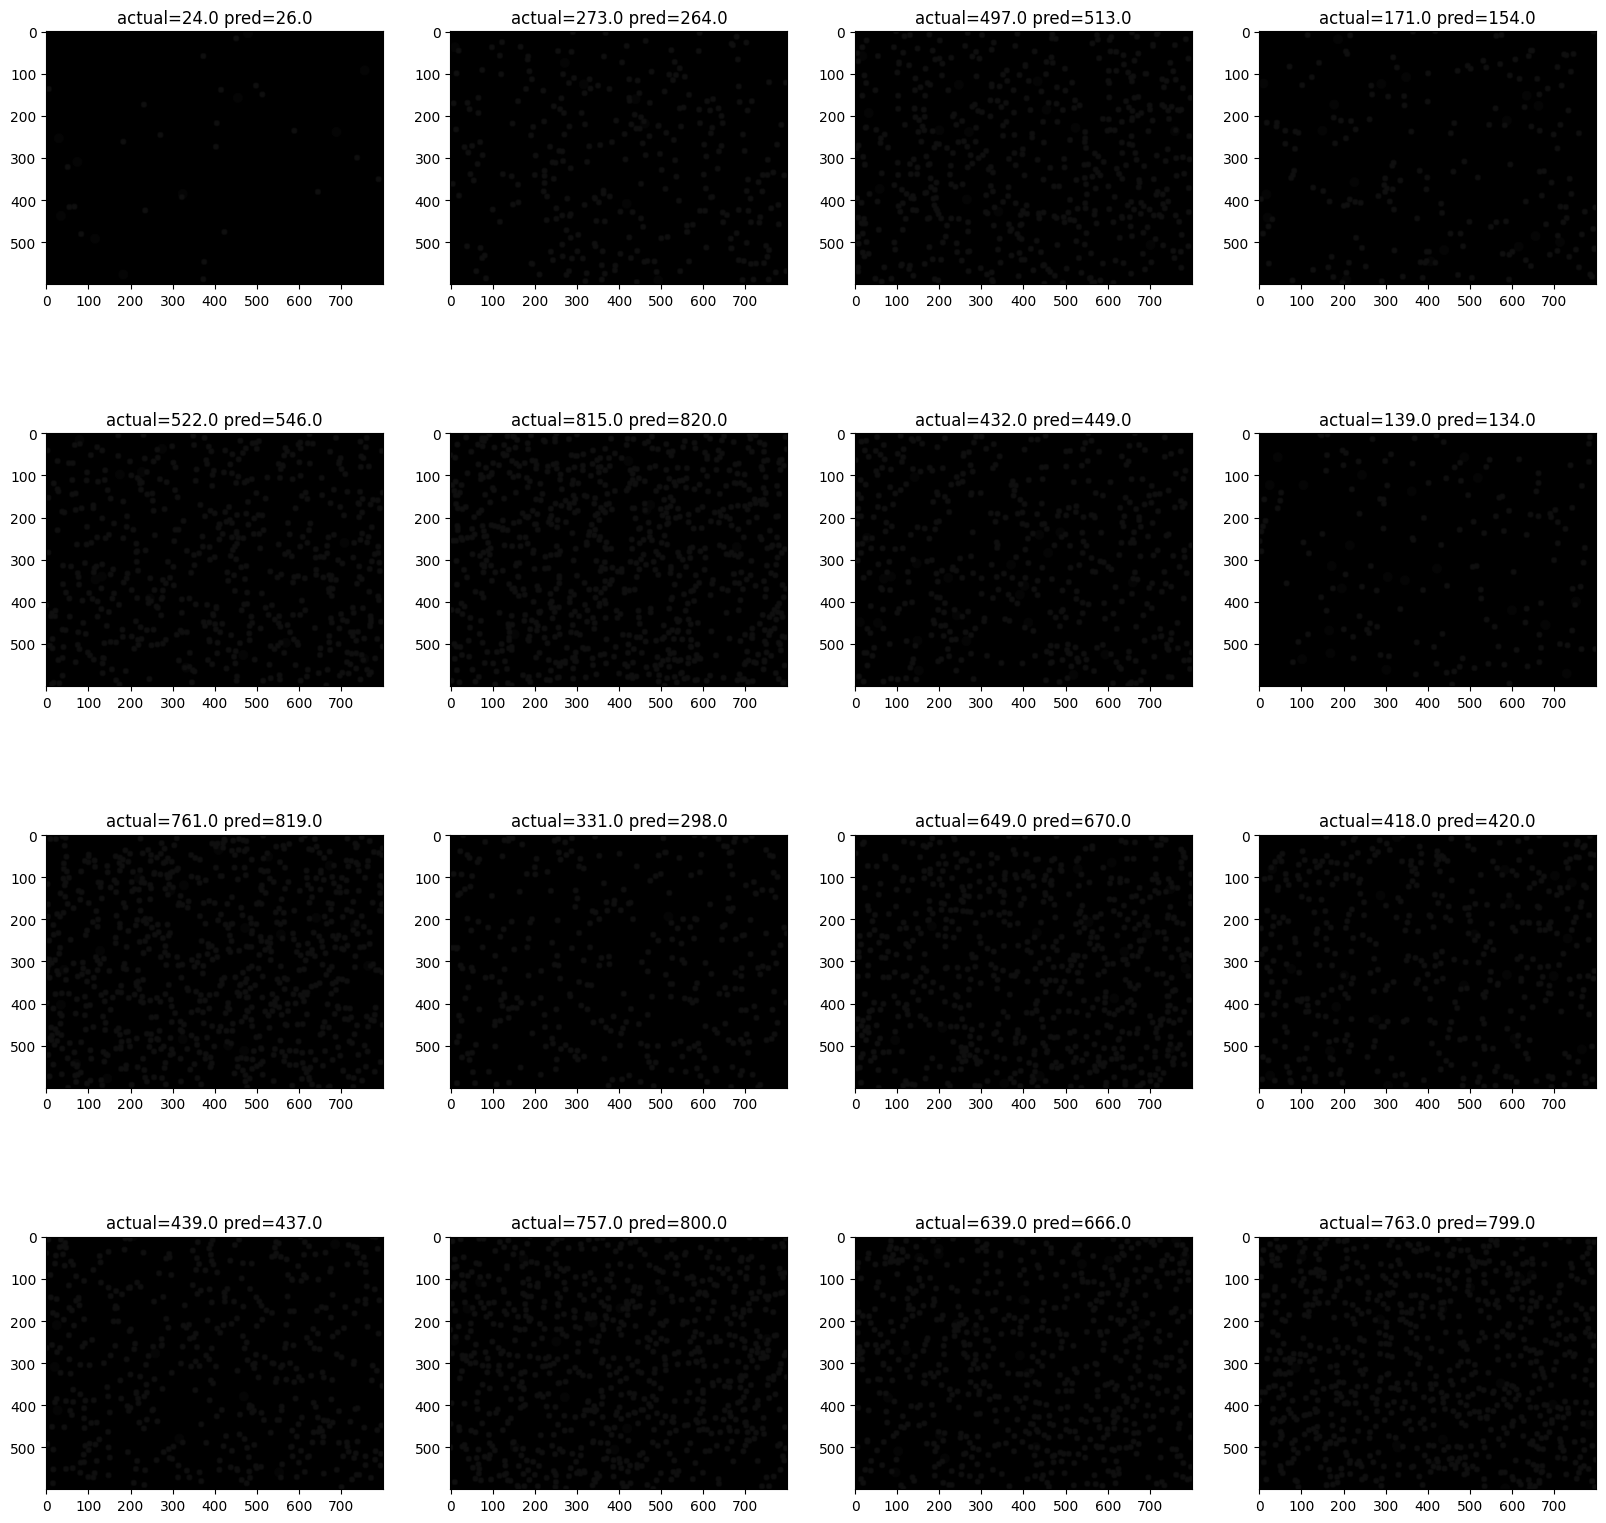

ACP value for the synthetic test dataset:  68.75


In [40]:
# visualization and ACP over the sythetic dataset 

syn_pred_list = []
syn_gt_list = []
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()


for idx in range(16):
  img, label =  generate_image()
  label_sum = torch.sum(torch.tensor(label))
  syn_pred_list.append(label_sum)
  pred_sum = count_cells(model, img) 
  pred_sum =  pred_sum.cpu().detach().numpy()//3
  syn_gt_list.append(pred_sum)
  img = Image.fromarray(img.astype(np.uint8))
  # ax.imshow(img)
  # img = torch.tensor(img)
  # img = to_numpy(img.permute(1, 2, 0))
    
  # img = Image.open(img)
  ax[idx // 4, idx % 4].imshow(img)
  ax[idx // 4, idx % 4].set_title("actual={:.1f} pred={:.1f}".format(label_sum, pred_sum))
  # break
plt.show()

#ACP value for the synthetic test dataset
acp = acp_estimate(syn_pred_list, syn_gt_list)
print("ACP value for the synthetic test dataset: ", acp)

In [19]:
#ACP evaluation for the actual test dataset

pred_list = []
gt_list = []
for file, label in zip(images_test, labels_test):
    img = cv2.imread(file).astype(np.float64)
    # print(img)
    img_1 = cv2.imread(file).astype(np.uint16)
    coord = pd.read_csv(label)
    label = np.zeros((img.shape[0], img.shape[1]))
    for k in range(coord.shape[0]):
        label[int(coord['Y'][k]), int(coord['X'][k])] = 1

    pred_sum = count_cells(model, img)
    pred_sum =  pred_sum.cpu().detach().numpy()//3
    # print("predicted", pred_sum)
    pred_list.append(pred_sum)


    label_sum = torch.sum(torch.tensor(label))
    # print("ground_truth", label_sum.item())
    gt_list.append(label_sum)
    
#ACP value for the 100 actual cell datasets    
acp = acp_estimate(pred_list, gt_list)
print("ACP score for the actual test dataset: ",  acp)
data_dicc["test_acp"].append(acp)

#Saving the results and hyperparameter to csv file
df = pd.DataFrame(data_dicc)
cell_counting_reslut = 'cell_counting_result.csv'
df.to_csv(cell_counting_reslut, index=False)

ACP score for the actual test dataset:  18.0


In [38]:
for val in data_dicc.values():
    print(val)

[0.001]
[100]
[1000]
[5.251063830322689]
[3.9318277875464966]
[4.387900969084903]
[2.9439426246764406]
[18.0]


In [24]:
len(images_test)

100

<Figure size 1000x500 with 0 Axes>

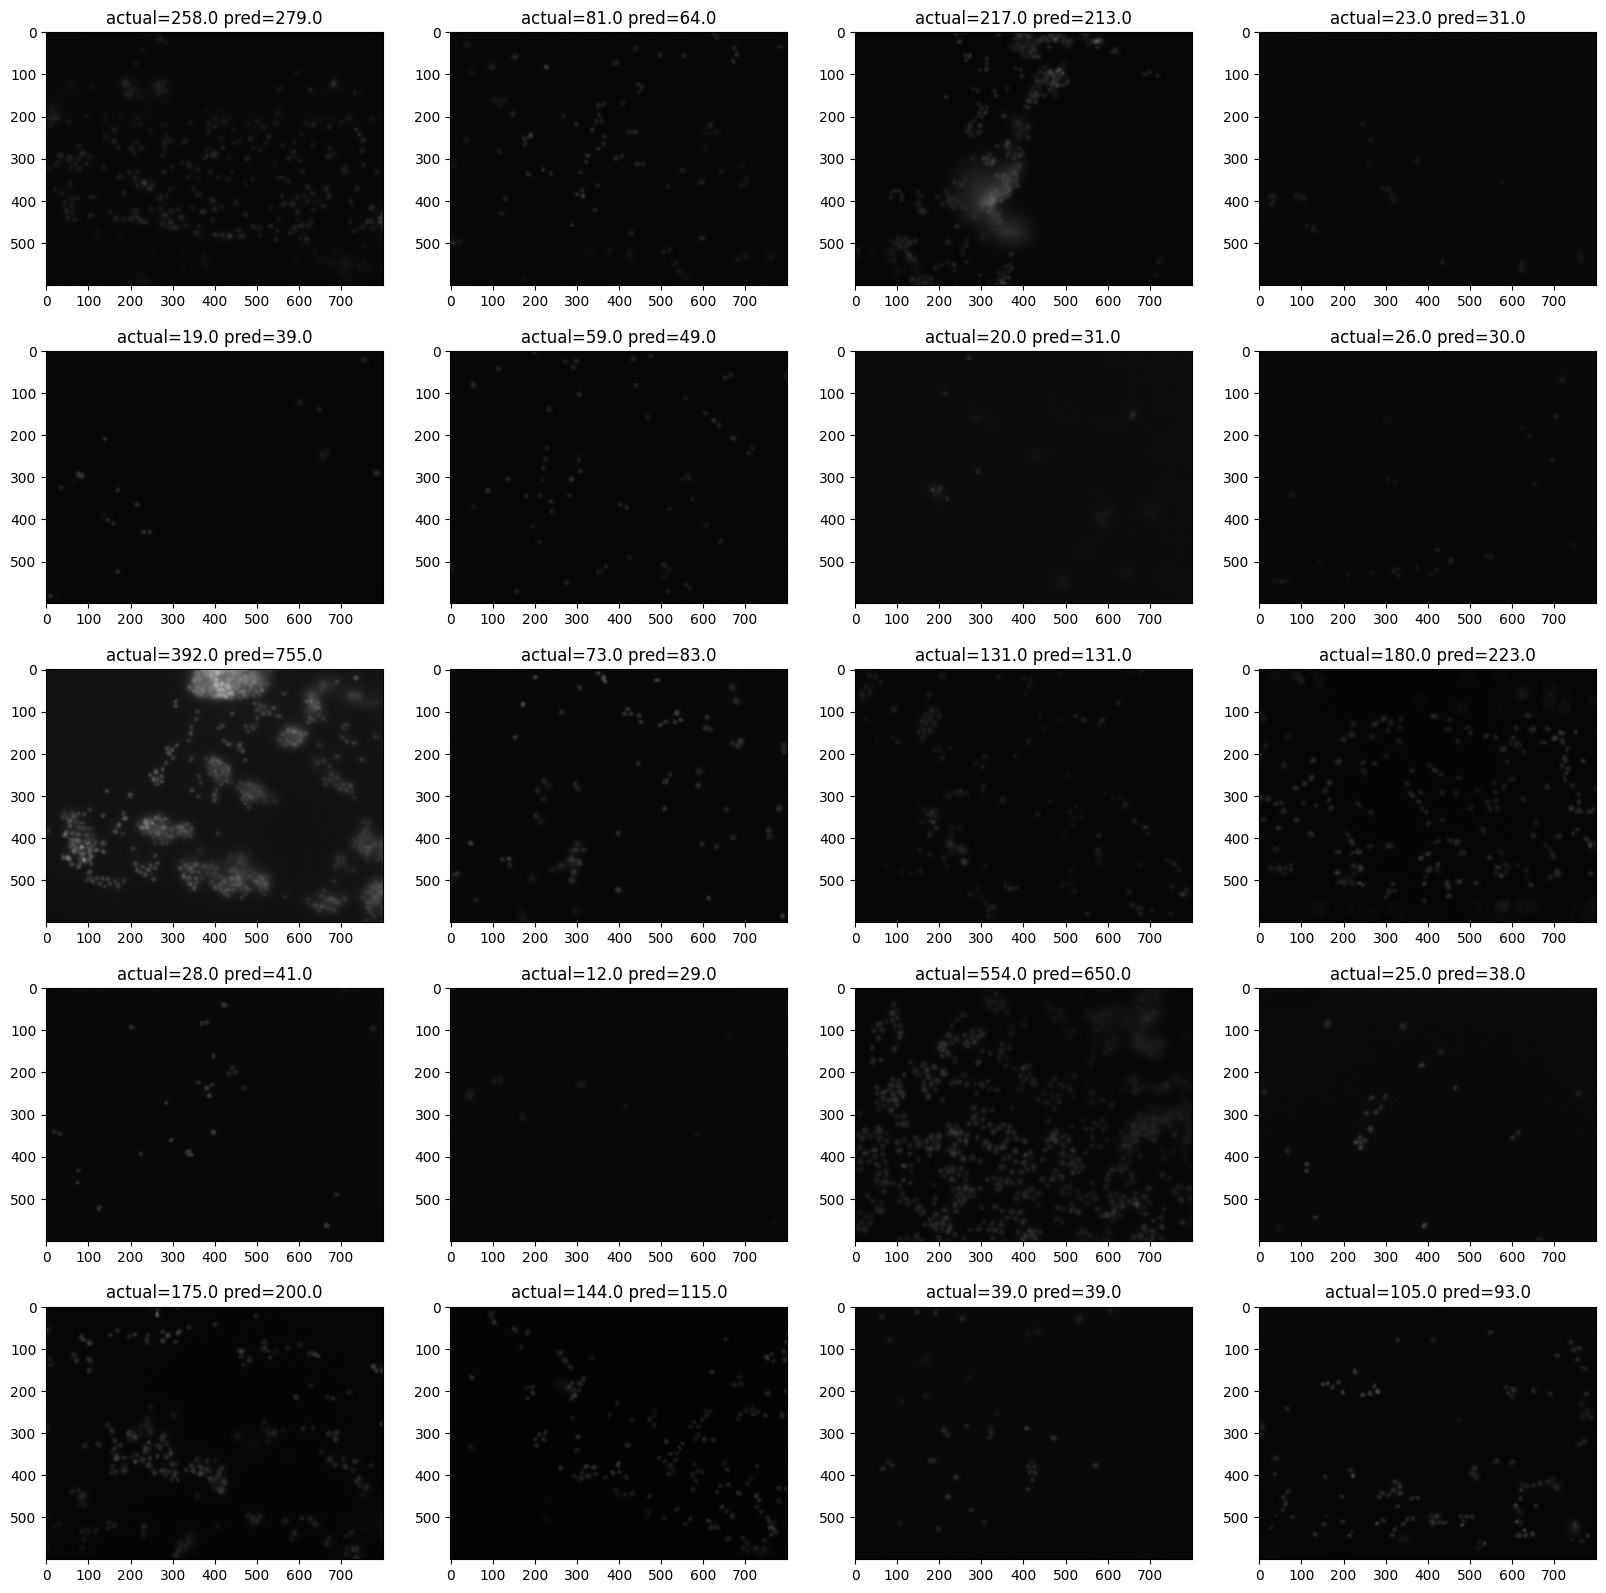

In [30]:
#Sample Visualization of the ground truth VS prediction over the test dataset

import matplotlib.pyplot as plt
import os
from PIL import Image

images_1 = images_test[:20]
labels_1 = labels_test[:20]

fig = plt.figure(figsize=(10, 5))
# i = 1
fig, ax = plt.subplots(5, 4, figsize=(20, 20))
pred_list = []
gt_list = []
idx = 0
for file, label in zip(images_1, labels_1):

        img = cv2.imread(file).astype(np.float64)
        # print(img)
        img_1 = cv2.imread(file).astype(np.uint16)
        coord = pd.read_csv(label)
        label = np.zeros((img.shape[0], img.shape[1]))
        for k in range(coord.shape[0]):
            label[int(coord['Y'][k]), int(coord['X'][k])] = 1

        pred_sum = count_cells(model, img)
        pred_sum =  pred_sum.cpu().detach().numpy()//3
        # print("predicted", pred_sum)
        pred_list.append(pred_sum)
        
        
        label_sum = torch.sum(torch.tensor(label))
        # print("ground_truth", label_sum.item())
        gt_list.append(label_sum)
        
        img = Image.fromarray(img.astype(np.uint8))
        ax[idx // 4, idx % 4].imshow(img_1)
        ax[idx // 4, idx % 4].set_title("actual={:.1f} pred={:.1f}".format(label_sum, pred_sum))
        idx = idx +1
        # break
plt.show()

In [13]:
import torch
model= torch.load("/work/LAS/qli-lab/yas/cell_counting_best_model.pt")
model.eval()

CellCountingModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [41]:
data_path = "IDCIA_test"

images_test = glob.glob(os.path.join(data_path, 'images_test', '*/*.tiff'))

In [42]:
type(images_test)

list

In [54]:
# for image in images_test:
#     print(image.split('/')[-1])
predict_test_dic = {image_path.split('/')[-1]:[] for image_path in images_test}

In [55]:
for img in images_test:
    image_name = img.split('/')[-1]
    # print(image_name)
    img = cv2.imread(img).astype(np.float64)
    pred_sum = count_cells(model, img)
    pred_sum =  pred_sum.cpu().detach().numpy()//3
   
    predict_test_dic[image_name].append(pred_sum)

In [56]:
df2 = pd.DataFrame(predict_test_dic)
predict_test_reslut = 'prediced_test_result.csv'
df2.to_csv(predict_test_reslut, index=False)